In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score

In [164]:
def compute_graph_covariance(df: pd.DataFrame, time_col: str = 't') -> dict:
    """
    Computes a 'graph covariance'-like matrix for each unique time step in `df`,
    returning each matrix as a DataFrame (so .loc indexing is supported).
    
    Steps:
      1. Split the data by unique time values,
      2. For each time step, convert the sub-DataFrame (minus the time column)
         to a NumPy array,
      3. Subtract the mean from each column (center the data),
      4. Normalize each column by its standard deviation,
      5. Compute the covariance-like matrix for that time step,
      6. Return a dictionary keyed by time with the resulting DataFrame.

    Returns
    -------
    dict
        Dictionary where each key is a unique time value and the value is a
        DataFrame containing the covariance-like matrix.
    """
    # Identify all columns other than time_col
    other_cols = [col for col in df.columns if col != time_col]
    
    # Split data into time steps
    unique_times = df[time_col].unique()
    gc_dict = {}

    for t_value in unique_times:
        # Subset the DataFrame to the current time step
        subset_df = df[df[time_col] == t_value].drop(columns=[time_col])
        data_t = subset_df.values.astype(float)

        if data_t.shape[0] < 2:
            continue

        # Mean-center the data
        n = data_t.shape[0]
        mean = data_t.mean(axis=0, keepdims=True)
        data_centered = data_t - mean

        # Normalize each column
        stds = data_centered.std(axis=0, ddof=1, keepdims=True)
        
        # Avoid division by zero
        stds[stds == 0] = 1.0
        data_centered /= stds

        # Compute the covariance-like matrix
        graph_covariance = (data_centered.T @ data_centered) / (n - 1)

        # Convert to DataFrame
        cov_df = pd.DataFrame(graph_covariance, 
                              index=subset_df.columns, 
                              columns=subset_df.columns)
        
        # Store the DataFrame
        gc_dict[t_value] = cov_df

    return gc_dict

# Graphing one csv

In [9]:
df = pd.read_csv("../non_categorical_gen_data.csv")
gc_matrices = compute_graph_covariance(df, time_col="t")

print("Graph covariance matrices by time:")
for t, mat in gc_matrices.items():
    print(f"\nTime {t}:")
    print(mat.round(3))

Graph covariance matrices by time:

Time 1:
       X1     X2     X3     X4     X5     X6     X7
X1  1.000  0.017  0.970  0.705  0.971  0.884  0.002
X2  0.017  1.000  0.016  0.018  0.019  0.021  0.002
X3  0.970  0.016  1.000  0.688  0.942  0.859 -0.004
X4  0.705  0.018  0.688  1.000  0.689  0.627  0.003
X5  0.971  0.019  0.942  0.689  1.000  0.858  0.004
X6  0.884  0.021  0.859  0.627  0.858  1.000 -0.000
X7  0.002  0.002 -0.004  0.003  0.004 -0.000  1.000

Time 2:
       X1     X2     X3     X4     X5     X6     X7
X1  1.000 -0.017  0.972  0.834  0.963  0.850  0.002
X2 -0.017  1.000 -0.010 -0.024 -0.016 -0.004 -0.003
X3  0.972 -0.010  1.000  0.811  0.935  0.828  0.001
X4  0.834 -0.024  0.811  1.000  0.801  0.705  0.001
X5  0.963 -0.016  0.935  0.801  1.000  0.818 -0.002
X6  0.850 -0.004  0.828  0.705  0.818  1.000  0.018
X7  0.002 -0.003  0.001  0.001 -0.002  0.018  1.000

Time 3:
       X1     X2     X3     X4     X5     X6     X7
X1  1.000  0.016  0.969  0.893  0.947  0.793  0.009
X2

In [10]:
times = sorted(gc_matrices.keys())

gc_12 = [gc_matrices[t].loc["X1","X2"] for t in times]  # (X1, X2)
gc_13 = [gc_matrices[t].loc["X1","X3"] for t in times]  # (X1, X3)
gc_14 = [gc_matrices[t].loc["X1","X4"] for t in times]  # (X1, X4)
gc_15 = [gc_matrices[t].loc["X1","X5"] for t in times]  # (X1, X5)
gc_16 = [gc_matrices[t].loc["X1","X6"] for t in times]  # (X1, X6)
gc_17 = [gc_matrices[t].loc["X1","X7"] for t in times]  # (X1, X7)

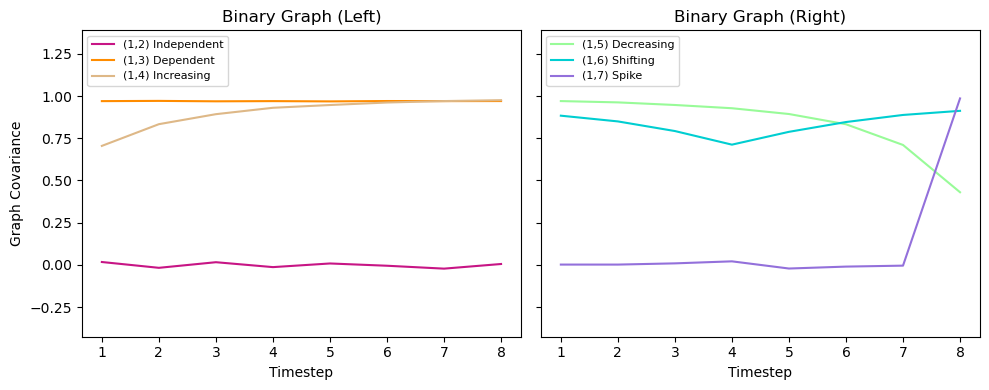

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Left: (X1,X2), (X1,X3), (X1,X4)
ax1.plot(times, gc_12, color='mediumvioletred', label='(1,2) Independent')
ax1.plot(times, gc_13, color='darkorange', label='(1,3) Dependent')
ax1.plot(times, gc_14, color='burlywood', label='(1,4) Increasing')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Graph Covariance')
ax1.set_title('Binary Graph (Left)')
ax1.legend(loc='upper left', fontsize='8')

# Right: (X1,X5), (X1,X6), (X1,X7)
ax2.plot(times, gc_15, color='palegreen', label='(1,5) Decreasing')
ax2.plot(times, gc_16, color='darkturquoise', label='(1,6) Shifting')
ax2.plot(times, gc_17, color='mediumpurple', label='(1,7) Spike')
ax2.set_xlabel('Timestep')
ax2.set_title('Binary Graph (Right)')
ax2.legend(loc='upper left', fontsize='8')

# Combine all data to determine the overall min and max
all_data = np.concatenate([gc_12, gc_13, gc_14, gc_15, gc_16, gc_17])
global_min = np.min(all_data)
global_max = np.max(all_data)

# Calculate a 20% margin on the range
data_range = global_max - global_min
margin = 0.4 * data_range

# Set the y-axis limits with an extra 20% margin
y_lower = global_min - margin
y_upper = global_max + margin
ax1.set_ylim(y_lower, y_upper)
ax2.set_ylim(y_lower, y_upper)

plt.tight_layout()
plt.show()

# Graphing two csvs

In [194]:
# Load two CSV files
df1 = pd.read_csv("Simulated Data/Normal (Non-Categorical)/non_categorical_gen_data.csv") # Original "ground truth"
df2 = pd.read_csv("Simulated Data/Normal (Non-Categorical)/non_categorical_gen_linreg_imputation.csv") # Imputed dataset

In [195]:
# Compute graph covariance for both datasets
gc_matrices1 = compute_graph_covariance(df1, time_col="t")
gc_matrices2 = compute_graph_covariance(df2, time_col="t")

# Ensure times are aligned (using intersection of time points)
times1 = sorted(gc_matrices1.keys())
times2 = sorted(gc_matrices2.keys())
common_times = sorted(set(times1) & set(times2))

In [196]:
# Extract covariance values for both datasets
gc1_12 = [gc_matrices1[t].loc["X1","X2"] for t in common_times]
gc1_13 = [gc_matrices1[t].loc["X1","X3"] for t in common_times]
gc1_14 = [gc_matrices1[t].loc["X1","X4"] for t in common_times]
gc1_15 = [gc_matrices1[t].loc["X1","X5"] for t in common_times]
gc1_16 = [gc_matrices1[t].loc["X1","X6"] for t in common_times]
gc1_17 = [gc_matrices1[t].loc["X1","X7"] for t in common_times]

gc2_12 = [gc_matrices2[t].loc["X1","X2"] for t in common_times]
gc2_13 = [gc_matrices2[t].loc["X1","X3"] for t in common_times]
gc2_14 = [gc_matrices2[t].loc["X1","X4"] for t in common_times]
gc2_15 = [gc_matrices2[t].loc["X1","X5"] for t in common_times]
gc2_16 = [gc_matrices2[t].loc["X1","X6"] for t in common_times]
gc2_17 = [gc_matrices2[t].loc["X1","X7"] for t in common_times]

In [197]:
# Shift second line to match first
def shift_series(base_series, imputed_series):
    """Shift imputed_series so that its first value matches the first value of base_series."""
    offset = base_series[0] - imputed_series[0]
    return [val + offset for val in imputed_series]

gc2_12_shifted = shift_series(gc1_12, gc2_12)
gc2_13_shifted = shift_series(gc1_13, gc2_13)
gc2_14_shifted = shift_series(gc1_14, gc2_14)
gc2_15_shifted = shift_series(gc1_15, gc2_15)
gc2_16_shifted = shift_series(gc1_16, gc2_16)
gc2_17_shifted = shift_series(gc1_17, gc2_17)

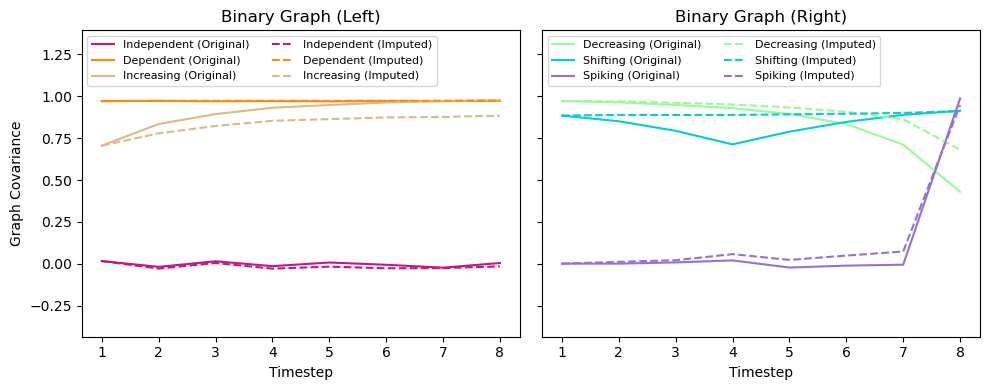

In [198]:
# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# LEFT PLOT: (X1,X2), (X1,X3), (X1,X4)
ax1.plot(common_times, gc1_12, color='mediumvioletred',   linestyle='-',  label='Independent (Original)')
ax1.plot(common_times, gc1_13, color='darkorange',        linestyle='-',  label='Dependent (Original)')
ax1.plot(common_times, gc1_14, color='burlywood',         linestyle='-',  label='Increasing (Original)')
ax1.plot(common_times, gc2_12_shifted, color='mediumvioletred', linestyle='--', label='Independent (Imputed)')
ax1.plot(common_times, gc2_13_shifted, color='darkorange',      linestyle='--', label='Dependent (Imputed)')
ax1.plot(common_times, gc2_14_shifted, color='burlywood',       linestyle='--', label='Increasing (Imputed)')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Graph Covariance')
ax1.set_title('Binary Graph (Left)')
ax1.legend(loc='upper left', fontsize='8', ncol=2)

# RIGHT PLOT: (X1,X5), (X1,X6), (X1,X7)
ax2.plot(common_times, gc1_15, color='palegreen',   linestyle='-', label='Decreasing (Original)')
ax2.plot(common_times, gc1_16, color='darkturquoise', linestyle='-', label='Shifting (Original)')
ax2.plot(common_times, gc1_17, color='mediumpurple', linestyle='-', label='Spiking (Original)')
ax2.plot(common_times, gc2_15_shifted, color='palegreen',   linestyle='--', label='Decreasing (Imputed)')
ax2.plot(common_times, gc2_16_shifted, color='darkturquoise', linestyle='--', label='Shifting (Imputed)')
ax2.plot(common_times, gc2_17_shifted, color='mediumpurple', linestyle='--', label='Spiking (Imputed)')
ax2.set_xlabel('Timestep')
ax2.set_title('Binary Graph (Right)')
ax2.legend(loc='upper left', fontsize='8', ncol=2)

# --- GLOBAL Y-LIMITS ---
all_data_original = np.concatenate([
    gc1_12, gc1_13, gc1_14,
    gc1_15, gc1_16, gc1_17
])
all_data_imputed = np.concatenate([
    gc2_12_shifted, gc2_13_shifted, gc2_14_shifted,
    gc2_15_shifted, gc2_16_shifted, gc2_17_shifted
])
all_data = np.concatenate([all_data_original, all_data_imputed])

global_min = np.min(all_data)
global_max = np.max(all_data)
data_range = global_max - global_min
margin = 0.4 * data_range
y_lower = global_min - margin
y_upper = global_max + margin

ax1.set_ylim(y_lower, y_upper)
ax2.set_ylim(y_lower, y_upper)

plt.tight_layout()
plt.show()

# Calculating Imputation Accuracy

In [185]:
df_true  = pd.read_csv("Simulated Data/Normal (Non-Categorical)/non_categorical_gen_data.csv") # Original "ground truth"
df_imputed = pd.read_csv("Simulated Data/Normal (Non-Categorical)/non_categorical_gen_kNN_imputation.csv") # Imputed dataset

In [186]:
cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

assert df_true.shape[0] == df_imputed.shape[0], "Dataframes do not have the same number of rows"
assert all(df_true['t'] == df_imputed['t']), "The time columns do not match row by row"

In [177]:
print("Percentage of 0s and 1s in original dataset (per variable):")
for col in cols:
    pct_0 = (df_true[col] == 0).mean() * 100
    pct_1 = (df_true[col] == 1).mean() * 100
    print(f"{col}: 0 -> {pct_0:.2f}%, 1 -> {pct_1:.2f}%")

Percentage of 0s and 1s in original dataset (per variable):
X1: 0 -> 0.00%, 1 -> 0.00%
X2: 0 -> 0.00%, 1 -> 0.00%
X3: 0 -> 0.00%, 1 -> 0.00%
X4: 0 -> 0.00%, 1 -> 0.00%
X5: 0 -> 0.00%, 1 -> 0.00%
X6: 0 -> 0.00%, 1 -> 0.00%
X7: 0 -> 0.00%, 1 -> 0.00%


## For binary values

In [ ]:
y_true = df_true[cols].values.flatten()      # Flatten 2D array into 1D
y_imputed = df_imputed[cols].values.flatten()

global_accuracy = accuracy_score(y_true, y_imputed)
global_precision = precision_score(y_true, y_imputed, zero_division=0)
global_recall = recall_score(y_true, y_imputed, zero_division=0)
global_f1 = f1_score(y_true, y_imputed, zero_division=0)

print("Global Metrics (all X columns combined):")
print(f"Concordance (Accuracy): {global_accuracy:.3f}")
print(f"Precision:               {global_precision:.3f}")
print(f"Recall:                  {global_recall:.3f}")
print(f"F1-Score:                {global_f1:.3f}")

ValueError: continuous is not supported

In [145]:
print("\nPer-Column Metrics:")
for col in cols:
    col_accuracy = accuracy_score(df_true[col], df_imputed[col])
    col_precision = precision_score(df_true[col], df_imputed[col], zero_division=0)
    col_recall = recall_score(df_true[col], df_imputed[col], zero_division=0)
    col_f1 = f1_score(df_true[col], df_imputed[col], zero_division=0)
    
    print(f"Column: {col}")
    print(f"  Accuracy:  {col_accuracy:.3f}")
    print(f"  Precision: {col_precision:.3f}")
    print(f"  Recall:    {col_recall:.3f}")
    print(f"  F1-Score:  {col_f1:.3f}")
    print("")


Per-Column Metrics:
Column: X1
  Accuracy:  0.910
  Precision: 0.994
  Recall:    0.546
  F1-Score:  0.705

Column: X2
  Accuracy:  0.994
  Precision: 0.998
  Recall:    0.938
  F1-Score:  0.967

Column: X3
  Accuracy:  0.965
  Precision: 0.997
  Recall:    0.804
  F1-Score:  0.890

Column: X4
  Accuracy:  0.969
  Precision: 0.982
  Recall:    0.726
  F1-Score:  0.835

Column: X5
  Accuracy:  0.948
  Precision: 0.931
  Recall:    0.432
  F1-Score:  0.591

Column: X6
  Accuracy:  0.958
  Precision: 0.949
  Recall:    0.607
  F1-Score:  0.740

Column: X7
  Accuracy:  0.904
  Precision: 0.749
  Recall:    0.206
  F1-Score:  0.323



In [146]:
def shift_series(base_series, imputed_series):
    """
    Shift imputed_series so that its first value matches 
    the first value of base_series.
    """
    if not base_series:  # if empty
        return imputed_series
    offset = base_series[0] - imputed_series[0]
    return [val + offset for val in imputed_series]

def mean_squared_error(series1, series2):
    diff = np.array(series1) - np.array(series2)
    return np.mean(diff ** 2)

In [150]:
gc_matrices1 = compute_graph_covariance(df_true, time_col="t")
gc_matrices2 = compute_graph_covariance(df_imputed, time_col="t")

times1 = sorted(gc_matrices1.keys())
times2 = sorted(gc_matrices2.keys())
common_times = sorted(set(times1) & set(times2))

# Example pairs: (X1,X2), (X1,X3), etc.
gc1_12 = [gc_matrices1[t].loc["X1","X2"] for t in common_times] if common_times else []
gc1_13 = [gc_matrices1[t].loc["X1","X3"] for t in common_times] if common_times else []
gc1_14 = [gc_matrices1[t].loc["X1","X4"] for t in common_times] if common_times else []
gc1_15 = [gc_matrices1[t].loc["X1","X5"] for t in common_times] if common_times else []
gc1_16 = [gc_matrices1[t].loc["X1","X6"] for t in common_times] if common_times else []
gc1_17 = [gc_matrices1[t].loc["X1","X7"] for t in common_times] if common_times else []

gc2_12 = [gc_matrices2[t].loc["X1","X2"] for t in common_times] if common_times else []
gc2_13 = [gc_matrices2[t].loc["X1","X3"] for t in common_times] if common_times else []
gc2_14 = [gc_matrices2[t].loc["X1","X4"] for t in common_times] if common_times else []
gc2_15 = [gc_matrices2[t].loc["X1","X5"] for t in common_times] if common_times else []
gc2_16 = [gc_matrices2[t].loc["X1","X6"] for t in common_times] if common_times else []
gc2_17 = [gc_matrices2[t].loc["X1","X7"] for t in common_times] if common_times else []

gc2_12_shifted = shift_series(gc1_12, gc2_12)
gc2_13_shifted = shift_series(gc1_13, gc2_13)
gc2_14_shifted = shift_series(gc1_14, gc2_14)
gc2_15_shifted = shift_series(gc1_15, gc2_15)
gc2_16_shifted = shift_series(gc1_16, gc2_16)
gc2_17_shifted = shift_series(gc1_17, gc2_17)

pairs_original = [gc1_12, gc1_13, gc1_14, gc1_15, gc1_16, gc1_17]
pairs_imputed  = [gc2_12_shifted, gc2_13_shifted, gc2_14_shifted,
                  gc2_15_shifted, gc2_16_shifted, gc2_17_shifted]
pair_names = ["(X1,X2)", "(X1,X3)", "(X1,X4)", "(X1,X5)", "(X1,X6)", "(X1,X7)"]

# Compute 1 - MSE for each pair
similarity_values = []
for orig_series, imp_series, name in zip(pairs_original, pairs_imputed, pair_names):
    if len(orig_series) == 0 or len(imp_series) == 0:
        print(f"\nNo data for pair {name}; cannot compute 1 - MSE.")
        similarity_values.append(np.nan)
        continue
    
    mse_val = mean_squared_error(orig_series, imp_series)
    similarity = 1 - mse_val   # 1 - MSE
    similarity_values.append(similarity)
    
    print(f"1 - MSE for {name}: {similarity:.4f}")

# Overall average of (1 - MSE) across all pairs
valid_sims = [val for val in similarity_values if not np.isnan(val)]
if len(valid_sims) > 0:
    avg_similarity = np.mean(valid_sims)
    print(f"\nAverage (1 - MSE) across all pairs: {avg_similarity:.4f}")
else:
    print("\nNo valid (1 - MSE) values to average.")

1 - MSE for (X1,X2): 0.9984
1 - MSE for (X1,X3): 0.9884
1 - MSE for (X1,X4): 0.9971
1 - MSE for (X1,X5): 0.9891
1 - MSE for (X1,X6): 0.9956
1 - MSE for (X1,X7): 0.9920

Average (1 - MSE) across all pairs: 0.9934


## For noncategorical values

In [187]:
y_true = df_true[cols].values.flatten()
y_imputed = df_imputed[cols].values.flatten()

mse_val = mean_squared_error(y_true, y_imputed)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_true, y_imputed)
r2_val = r2_score(y_true, y_imputed)

print("Regression Metrics (all continuous columns combined):")
print(f"MSE:   {mse_val:.3f}")
print(f"RMSE:  {rmse_val:.3f}")
print(f"MAE:   {mae_val:.3f}")
print(f"R^2:   {r2_val:.3f}")

Regression Metrics (all continuous columns combined):
MSE:   2.485
RMSE:  1.576
MAE:   0.783
R^2:   0.393
